In [1]:
from typing import List
from typing import Tuple
from typing import Dict
from typing import Any
from typing import Optional

import os
import json
from collections import defaultdict

import numpy as np
import pandas as pd
import sklearn as sk
import statsmodels as sm

%matplotlib inline
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from tbats import TBATS, BATS

# Data Loading

In [2]:
sleep_df: pd.DataFrame = pd.read_feather('data/processed/fitness_df.feather')
sleep_df.set_index('date', inplace=True)

In [3]:
IMG_ROOT: str = 'export/images/raw/'
os.makedirs(IMG_ROOT, exist_ok=True)
if os.path.exists("logs.log"):
    os.remove("logs.log")

# TBATS

In [4]:
def learn_tbats(target_series: pd.Series) -> TBATS:
    """ Learns TBATS model.
    
    Args:
        target_series: The series to fit into TBATS.
    
    Returns: 
        The learned TBATS model.
    """
    tbats_estimator: TBATS = TBATS(seasonal_periods=[7])
    tbats_model: TBATS = tbats_estimator.fit(target_series)
    return tbats_model

In [5]:
def plot_tbats(tbats_model: TBATS, target_series: pd.Series, target_title: str) -> None:
    """ Plots learned TBATS model.
    
    Args:
        tbats_model: The learned TBATS model.
        target_series: The target series.
        target_title: The human-readable title for the target series.
    """
    plt.figure(figsize=(16, 4))
    PERIODS_AHEAD: int = 30
        
    y_forecast: Any; confidence_info: Any
    y_forecast, confidence_info = tbats_model.forecast(steps=PERIODS_AHEAD, confidence_level=0.95)

    index_of_fc: Any = pd.date_range(sleep_df.index[-1], periods = PERIODS_AHEAD + 1, freq='D')[1:]
    fitted_series: pd.Series = pd.Series(y_forecast, index=index_of_fc)
    lower_series: pd.Series = pd.Series(confidence_info['lower_bound'], index=index_of_fc)
    upper_series: pd.Series = pd.Series(confidence_info['upper_bound'], index=index_of_fc)
    
    plt.plot(target_series, label='Initial Data')
    plt.plot(fitted_series, label='TBATS Forecast')
    plt.fill_between(index_of_fc, lower_series, upper_series, alpha=0.15)
    plt.title("TBATS: " + target_title)
    plt.legend()
    image_name: str = 'tbats_' + target_title.lower().replace(" ", "_") + ".png"
    plt.savefig(os.path.join(IMG_ROOT, image_name))
    plt.show()

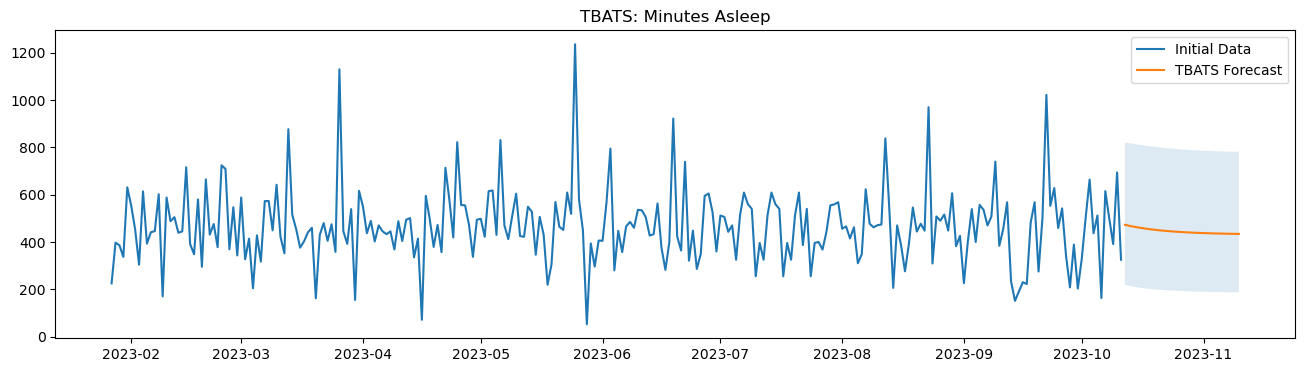

In [6]:
tbats_model: TBATS = learn_tbats(sleep_df['sleep'])
plot_tbats(tbats_model, sleep_df['sleep'], "Minutes Asleep")

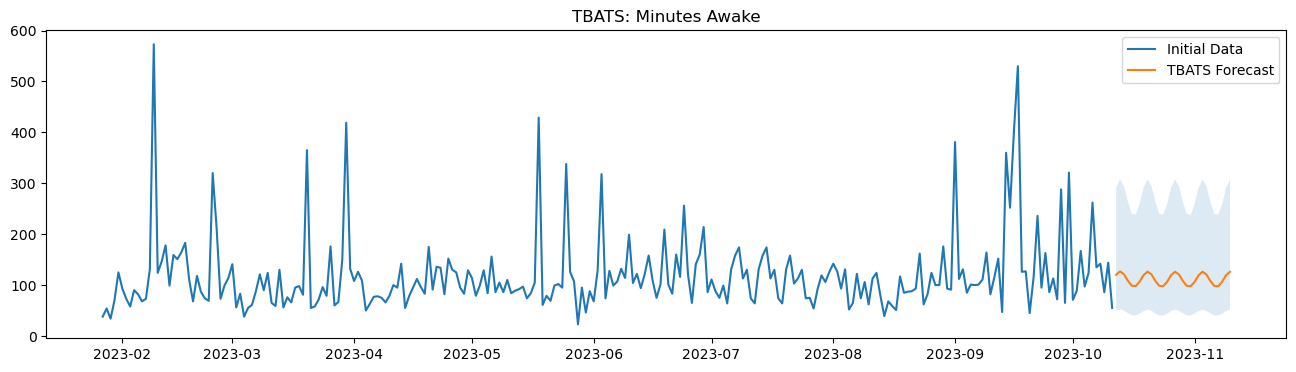

In [7]:
tbats_model: TBATS = learn_tbats(sleep_df['awake'])
plot_tbats(tbats_model, sleep_df['awake'], "Minutes Awake")

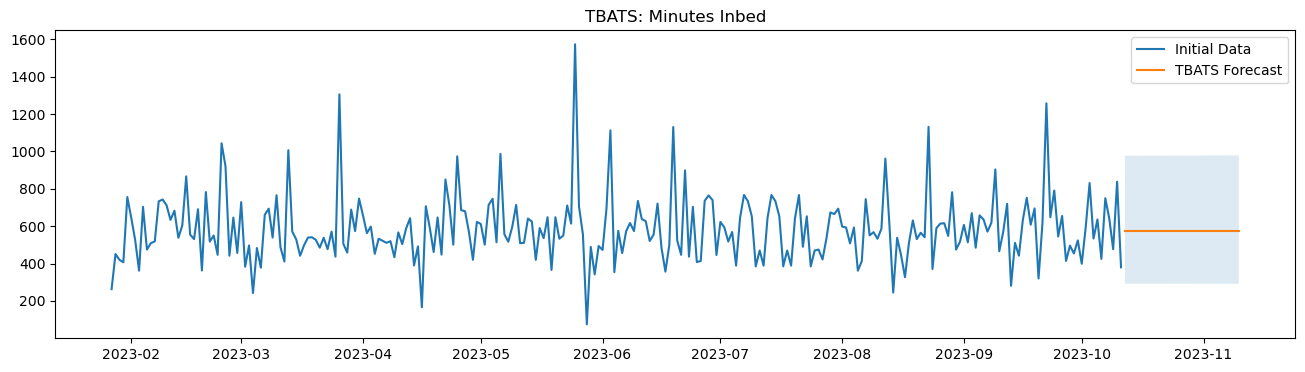

In [8]:
tbats_model: TBATS = learn_tbats(sleep_df['inbed'])
plot_tbats(tbats_model, sleep_df['inbed'], "Minutes Inbed")

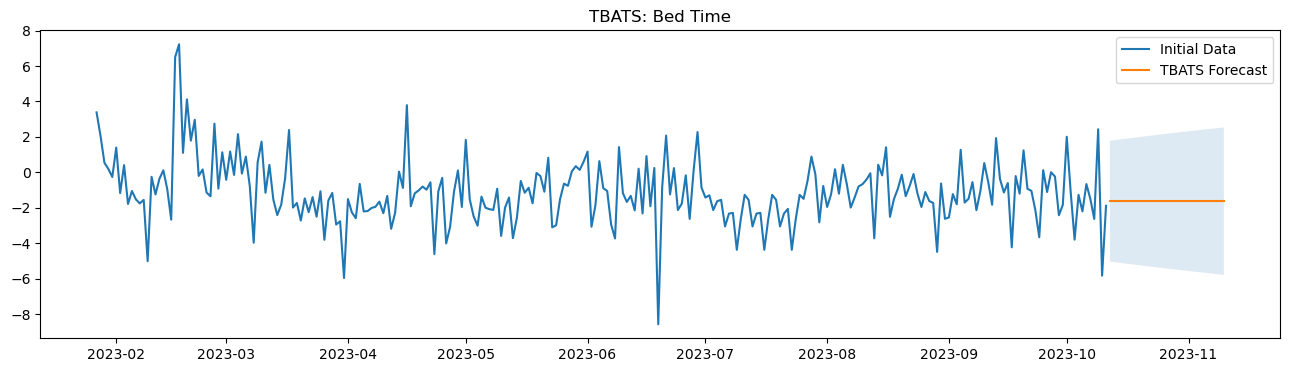

In [9]:
tbats_model:TBATS = learn_tbats(sleep_df['bed_time'])
plot_tbats(tbats_model, sleep_df['bed_time'], "Bed Time")

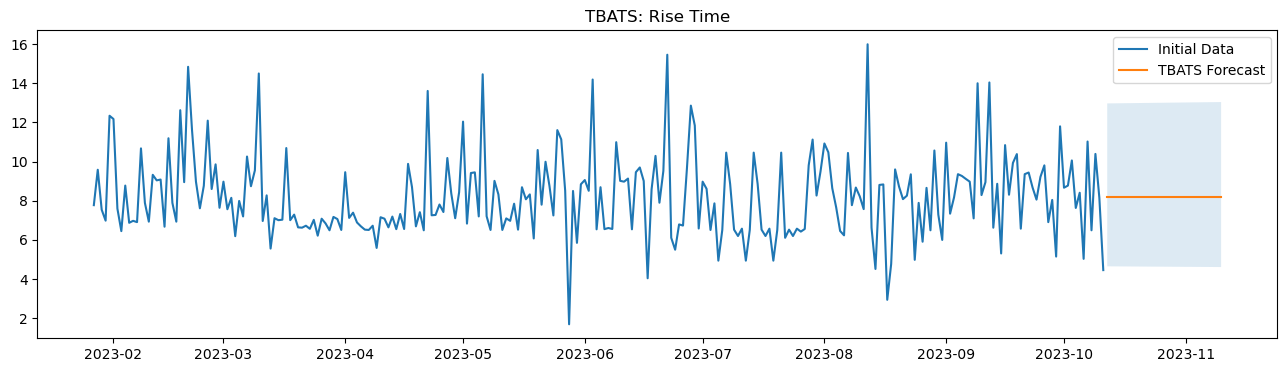

In [10]:
tbats_model: TBATS = learn_tbats(sleep_df['rise_time'])
plot_tbats(tbats_model, sleep_df['rise_time'], "Rise Time")

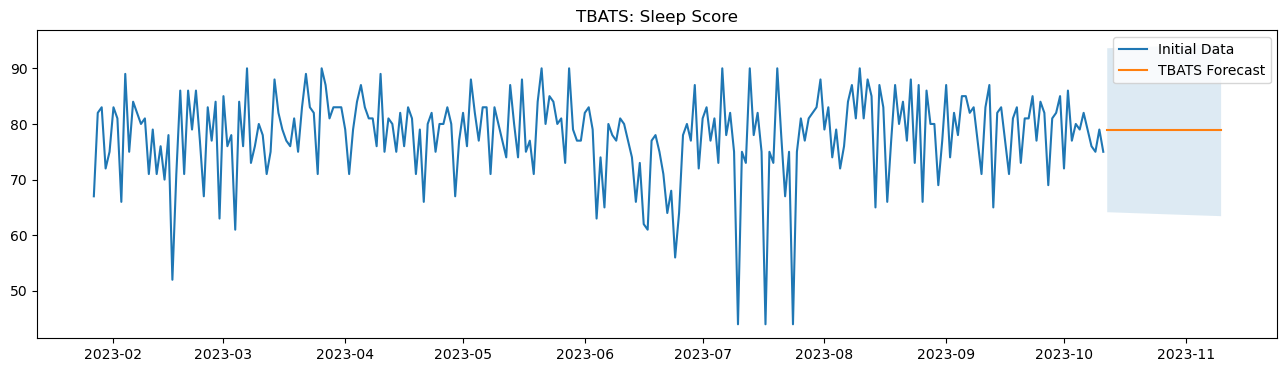

In [11]:
tbats_model: TBATS = learn_tbats(sleep_df['sleep_score'])
plot_tbats(tbats_model, sleep_df['sleep_score'], "Sleep Score")

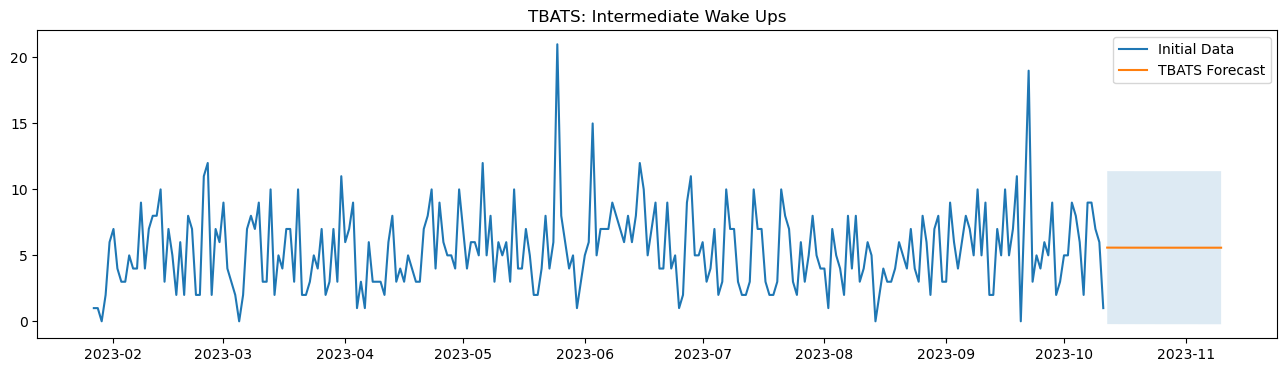

In [12]:
tbats_model: TBATS = learn_tbats(sleep_df['n_intermediate_wake_ups'])
plot_tbats(tbats_model, sleep_df['n_intermediate_wake_ups'], "Intermediate Wake Ups")

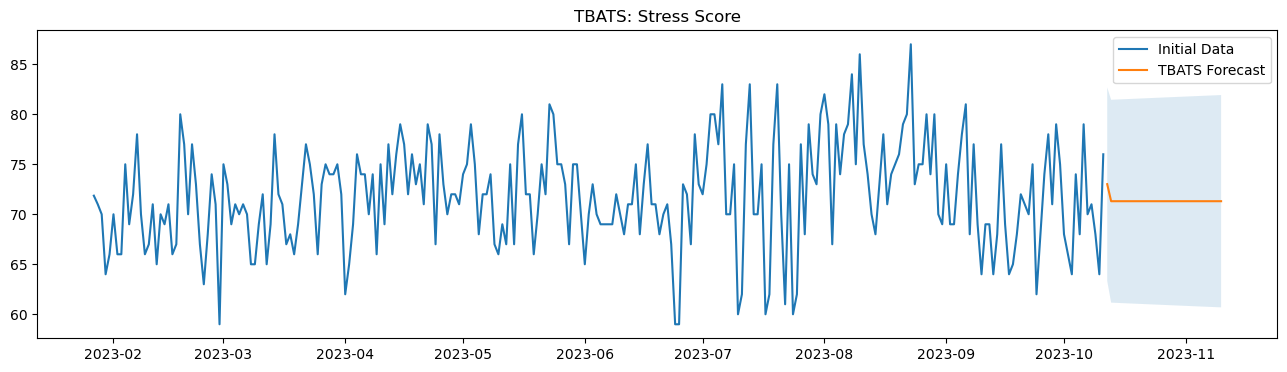

In [13]:
tbats_model: TBATS = learn_tbats(sleep_df['stress_today'])
plot_tbats(tbats_model, sleep_df['stress_today'], "Stress Score")

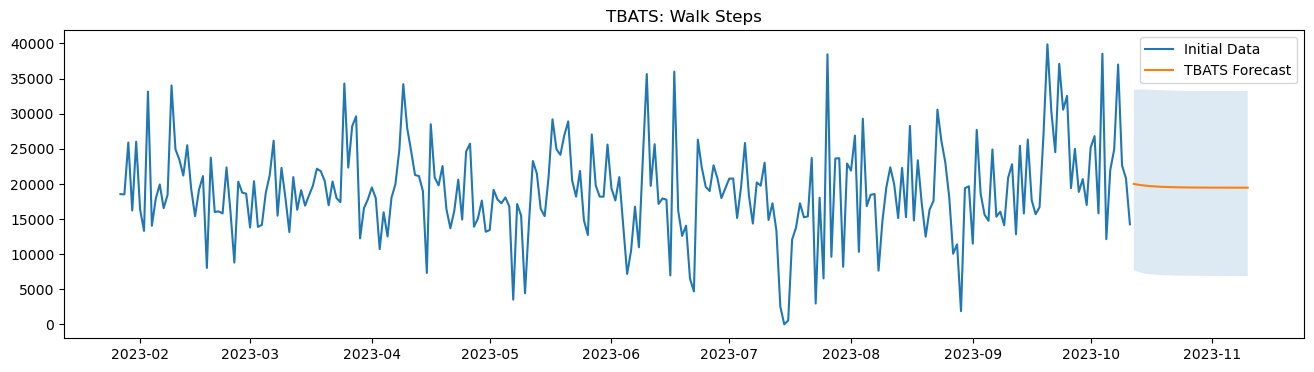

In [14]:
tbats_model: TBATS = learn_tbats(sleep_df['walk_today'])
plot_tbats(tbats_model, sleep_df['walk_today'], "Walk Steps")

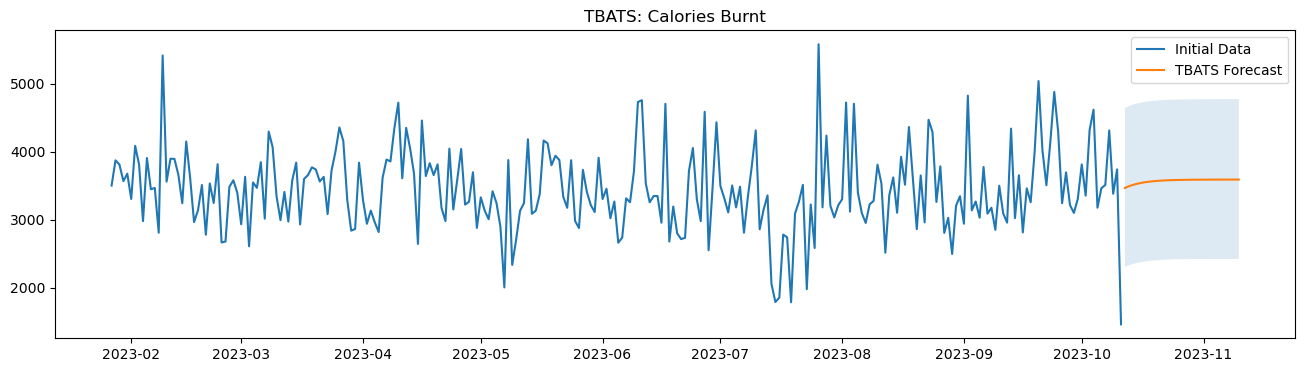

In [15]:
tbats_model: TBATS = learn_tbats(sleep_df['calories_today'])
plot_tbats(tbats_model, sleep_df['calories_today'], "Calories Burnt")

# SARIMAX

In [16]:
def learn_sarimax(target_series: pd.Series, exogenous_regressor: Optional[np.array]) -> Any:
    """ Learns SARIMAX model. 
    
    Args:
        target_series: The series to fit and forecast.
        exogenous_regressor: The series with exogenous regressor.
    
    Returns:
        The learned SARIMAX model.
    """
    model_sarimax: Any = pm.auto_arima(
        target_series, seasonal=True, m=7, transparams=True,
        start_p=1, start_q=1, start_d=1, start_P=1, start_Q=1, start_D=1,
        max_p=7, max_q=7, max_d=7,max_D=7, max_P=7, max_Q=7,
        max_order=12, maxiter=500, stationary=True, error_action='ignore',  
        suppress_warnings=True, exogenous=exogenous_regressor)
    return model_sarimax

In [17]:
def plot_sarimax(
        model_sarimax: Any, target_series: pd.Series, exogenous_regressor: Optional[np.array], 
        parameter_title: str, n_periods: int) -> None:
    """ Plots SARIMAX forecast.
    
    Args:
        model_sarimax: The learned SARIMAX model.
        target_series: The series used for fitting.
        exogenous_regressor: The values for the exogenous regressor 
            during the forecasting periods, if relevant. 
        parameter_title: The human-readable title for the target series.
        n_periods: The number of periods to forecast.
    """
    plt.figure(figsize=(16 ,4))
    
    fitted: Any; confint: Any
    fitted, confint = model_sarimax.predict(n_periods, return_conf_int=True, exogenous=exogenous_regressor)
    index_of_fc: Any = pd.date_range(sleep_df.index[-1], periods = n_periods + 1, freq='D')[1:]

    fitted_series: pd.Series = pd.Series(fitted, index=index_of_fc)
    lower_series: pd.Series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series: pd.Series = pd.Series(confint[:, 1], index=index_of_fc)

    plt.plot(target_series)
    plt.plot(fitted_series)
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     alpha=.15)
    plt.title(f"30-days forecast with Seasonal ARIMA - {parameter_title}")
    
    image_name: str = 'sarimax_' + parameter_title.lower().replace(" ", "_") + ".png"
    plt.savefig(os.path.join(IMG_ROOT, image_name))
    plt.show()

In [18]:
n_periods: int = 30
calories: np.array = np.zeros(n_periods, dtype=np.float32)
idx: int
for idx in range(n_periods):
    period_length: int = 7
    idx_mod: int = idx % period_length
    calories[idx] = np.mean(sleep_df['calories_before_sleep'].values[idx_mod:][::period_length])

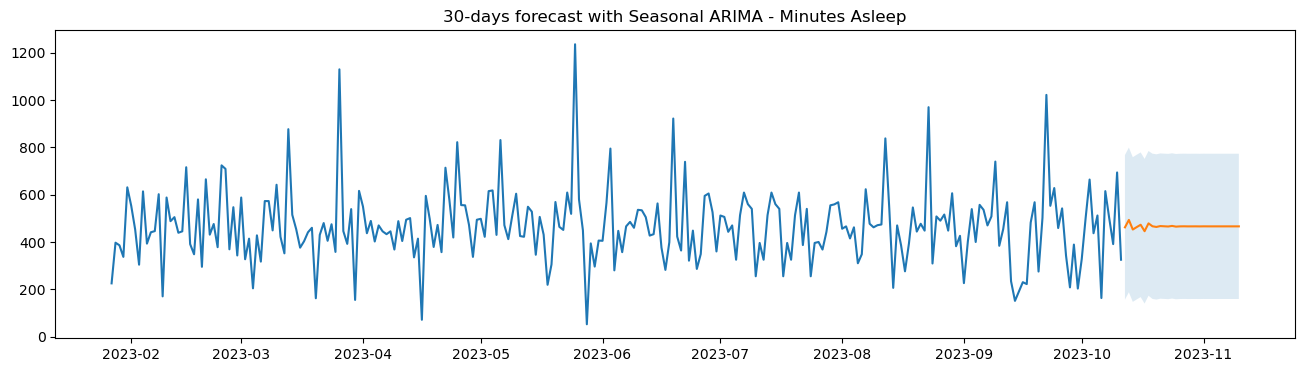

In [19]:
model_sarimax: Any = learn_sarimax(sleep_df['sleep'], sleep_df['calories_before_sleep'])
plot_sarimax(model_sarimax, sleep_df['sleep'], calories, 'Minutes Asleep', n_periods)

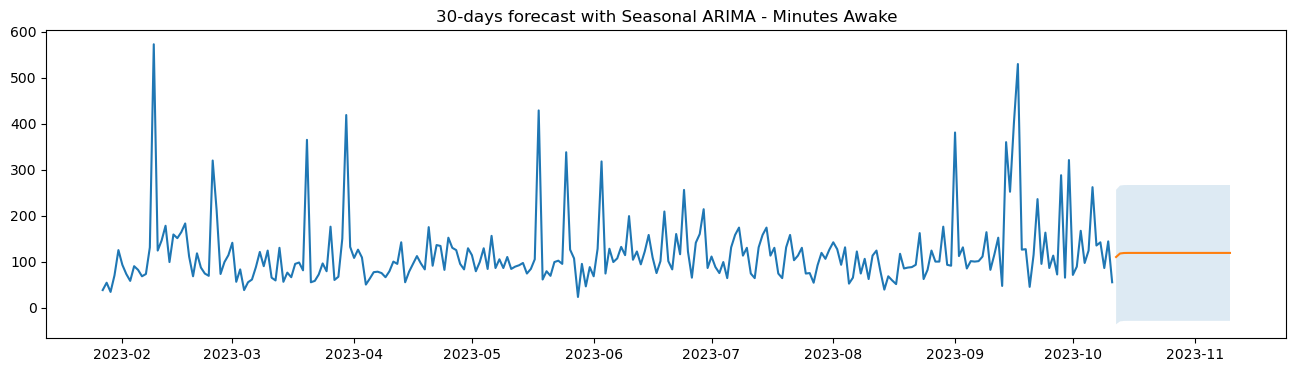

In [20]:
model_sarimax: Any = learn_sarimax(sleep_df['awake'], sleep_df['calories_before_sleep'])
plot_sarimax(model_sarimax, sleep_df['awake'], calories, 'Minutes Awake', n_periods)

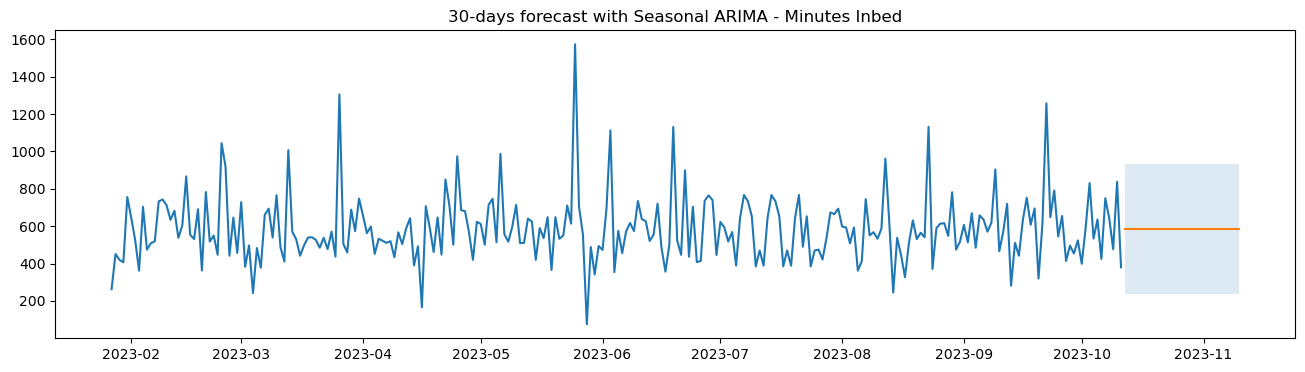

In [21]:
model_sarimax: Any = learn_sarimax(sleep_df['inbed'], sleep_df['calories_before_sleep'])
plot_sarimax(model_sarimax, sleep_df['inbed'], calories, 'Minutes Inbed', n_periods)

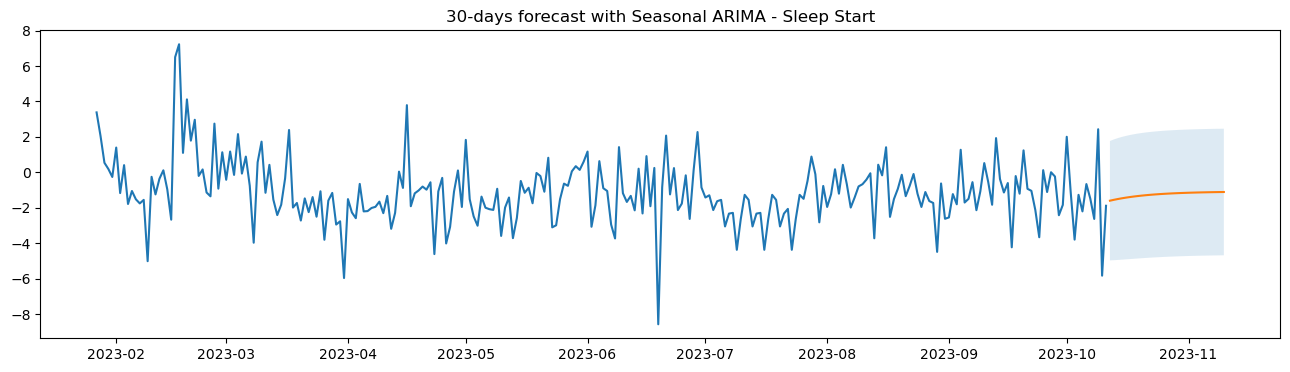

In [22]:
model_sarimax: Any = learn_sarimax(sleep_df['bed_time'], sleep_df['calories_before_sleep'])
plot_sarimax(model_sarimax, sleep_df['bed_time'], calories, 'Sleep Start', n_periods)

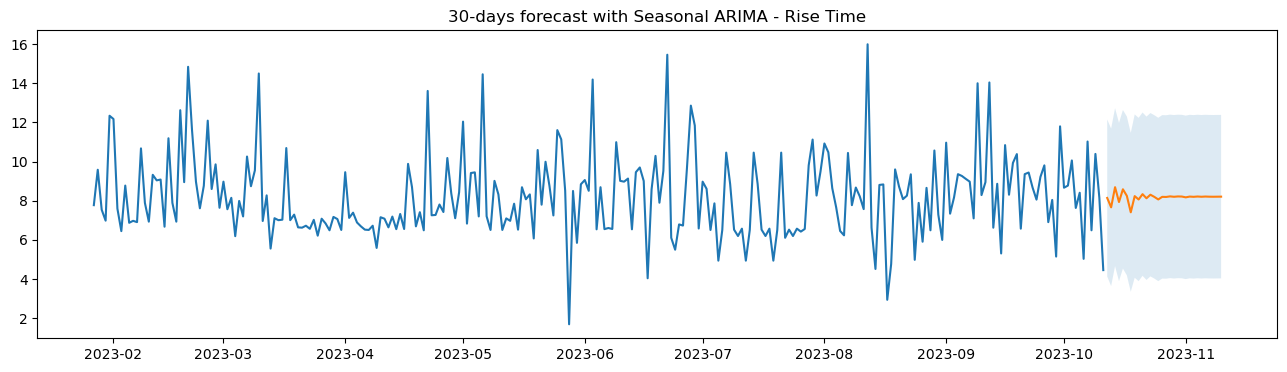

In [23]:
model_sarimax: Any = learn_sarimax(sleep_df['rise_time'], sleep_df['calories_before_sleep'])
plot_sarimax(model_sarimax, sleep_df['rise_time'], calories, 'Rise Time', n_periods)

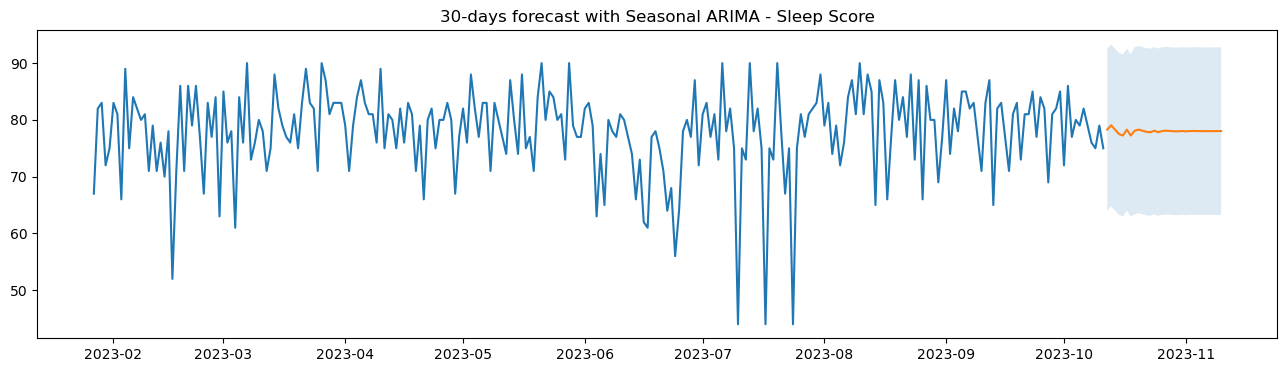

In [24]:
model_sarimax: Any = learn_sarimax(sleep_df['sleep_score'], None)
plot_sarimax(model_sarimax, sleep_df['sleep_score'], None, 'Sleep Score', n_periods)

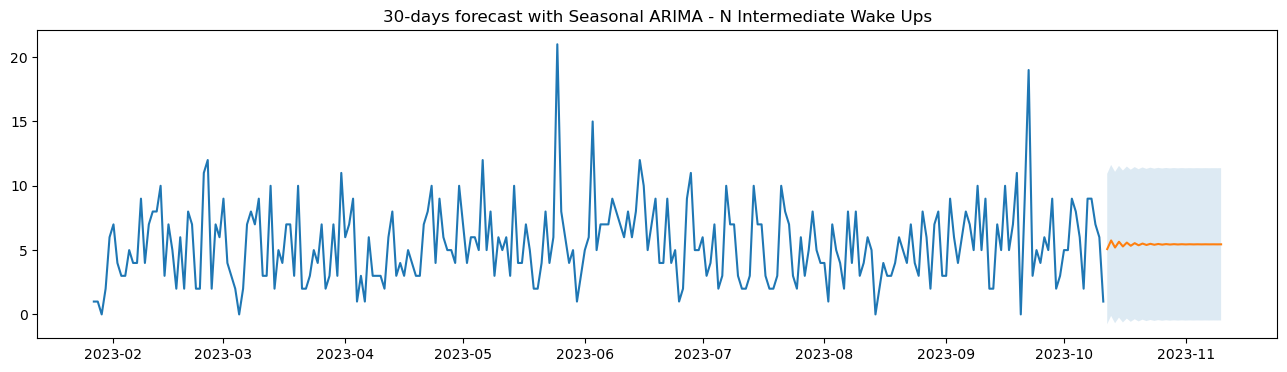

In [25]:
model_sarimax: Any = learn_sarimax(sleep_df['n_intermediate_wake_ups'], sleep_df['calories_before_sleep'])
plot_sarimax(model_sarimax, sleep_df['n_intermediate_wake_ups'], sleep_df['sleep_score'], 'N Intermediate Wake Ups', n_periods)

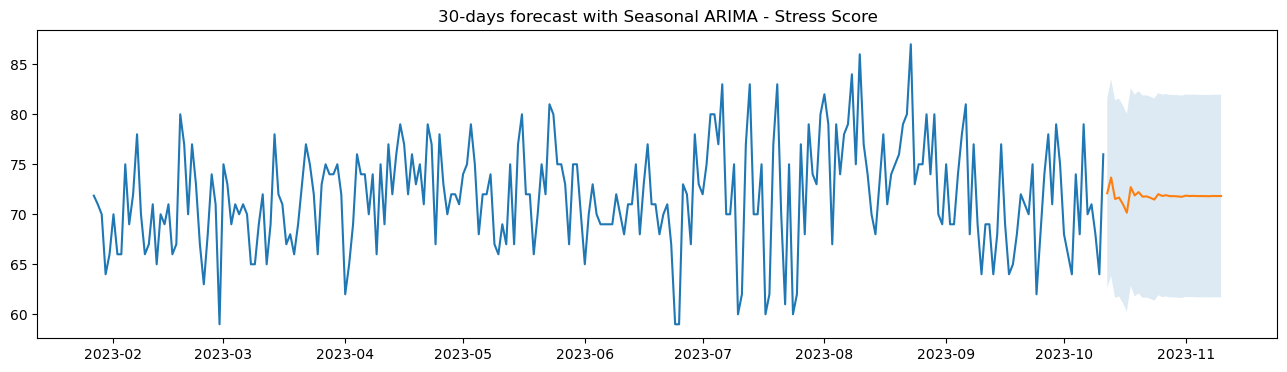

In [26]:
model_sarimax: Any = learn_sarimax(sleep_df['stress_today'], None)
plot_sarimax(model_sarimax, sleep_df['stress_today'], None, 'Stress Score', n_periods)

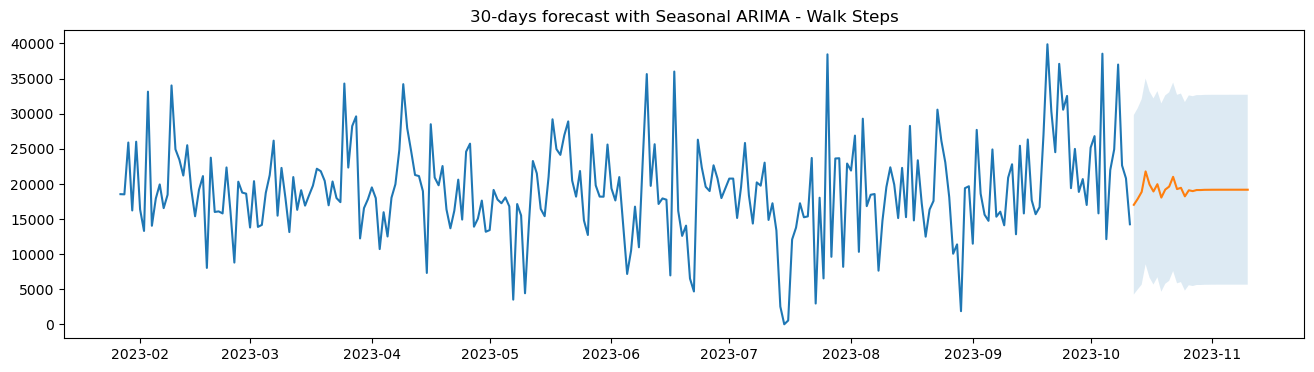

In [27]:
model_sarimax: Any = learn_sarimax(sleep_df['walk_today'], None)
plot_sarimax(model_sarimax, sleep_df['walk_today'], None, 'Walk Steps', n_periods)

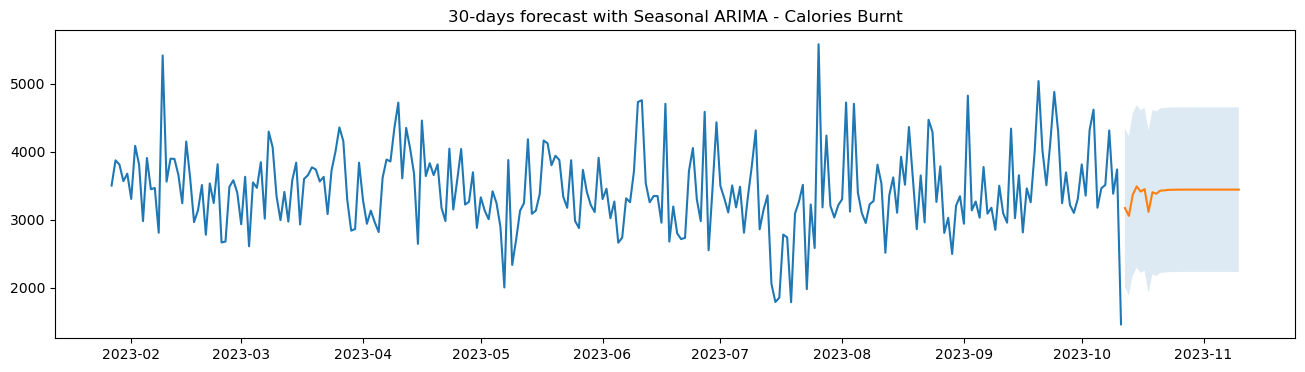

In [28]:
model_sarimax: Any = learn_sarimax(sleep_df['calories_today'], None)
plot_sarimax(model_sarimax, sleep_df['calories_today'], None, 'Calories Burnt', n_periods)